In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tig-aluminium-5083/al5083/README
/kaggle/input/tig-aluminium-5083/al5083/test/test.json
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00444.png
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00192.png
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00540.png
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00232.png
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00481.png
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00195.png
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00459.png
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00368.png
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00578.png
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00485.png
/kaggle/input/tig-aluminium-5083/al5083/test/170913-154448-Al 2mm/frame_00199.

In [8]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 55.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.3 MB/s eta 0:00:00:00:01


In [9]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as img
import json
import pandas as pd

2024-08-10 02:50:03.454611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 02:50:03.454782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 02:50:03.610837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(974, 800)

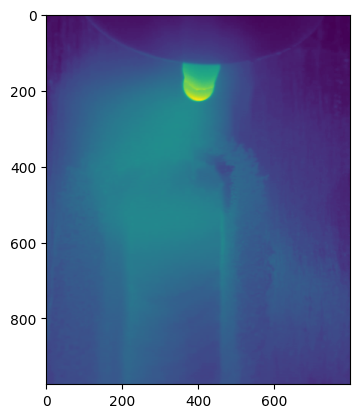

In [10]:
base_path = "/kaggle/input/tig-aluminium-5083/al5083/al5083/train/"
filename = "170913-142501-Al 2mm/frame_00798.png"
image_array = img.imread(base_path + filename)

plt.imshow(image_array)
image_array.shape

In [11]:
# dev = qml.device('default.qubit', wires=20)

#### 20 qubits for x and y axes.
#### Add padding to the image.

In [12]:
# def add_H():
#     for wire in range(20):
#         qml.Hadamard(wire=wire)

In [13]:
padding = np.ones((len(image_array), (1024-len(image_array[0]))//2))*0.01
image_array_padded = np.c_[image_array, padding]
image_array_padded = np.c_[padding, image_array_padded]

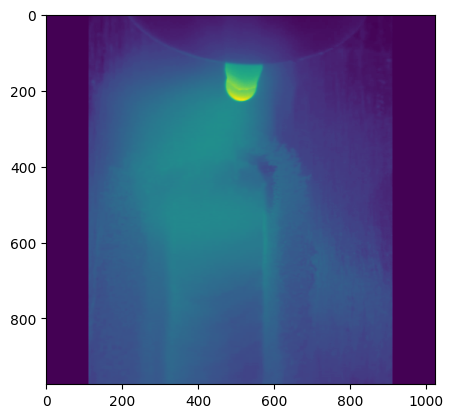

In [14]:
plt.imshow(image_array_padded)

In [15]:
padding = np.ones(((1024-len(image_array_padded))//2, len(image_array_padded[0])))*0.01
image_array_padded = np.concatenate((image_array_padded, padding), axis=0)
image_array_padded = np.concatenate((padding, image_array_padded), axis=0)

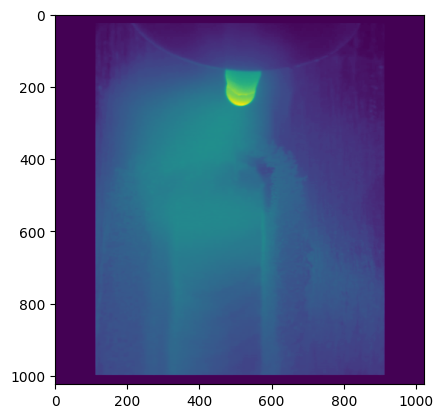

In [16]:
plt.imshow(image_array_padded)

In [17]:
image_array_padded.shape

(1024, 1024)

#### Image normalization

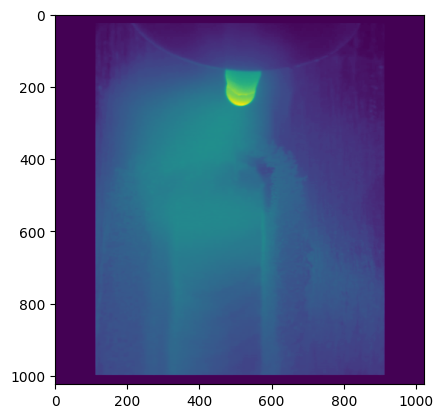

In [18]:
image_float = image_array_padded.astype(float)

min_val = np.min(image_float)
max_val = np.max(image_float)

norm_image_array_padded = (image_float - min_val) / (max_val - min_val)
image_array_padded = norm_image_array_padded
plt.imshow(image_array_padded)

/opt/conda/lib/python3.10/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


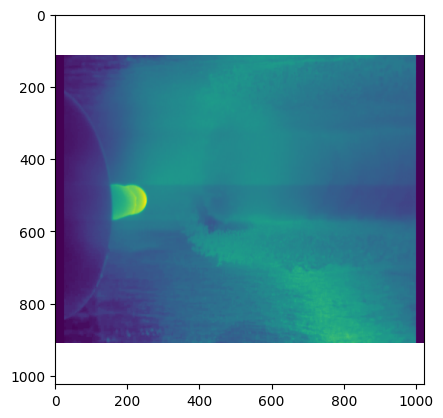

In [19]:
image_array_padded = image_array_padded.T

for row_index, row in enumerate(image_array_padded):
    pixel_sum_sq = 0
    for pixel in row:
        pixel_sum_sq += pixel**2
    pixel_sum_sq = np.sqrt(pixel_sum_sq)
    image_array_padded[row_index] = image_array_padded[row_index]/pixel_sum_sq

plt.imshow(image_array_padded)

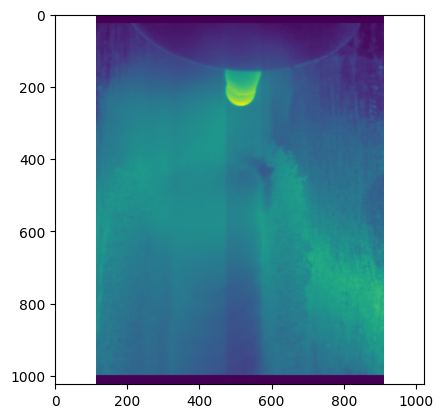

In [20]:
image_array_padded = image_array_padded.T
plt.imshow(image_array_padded)

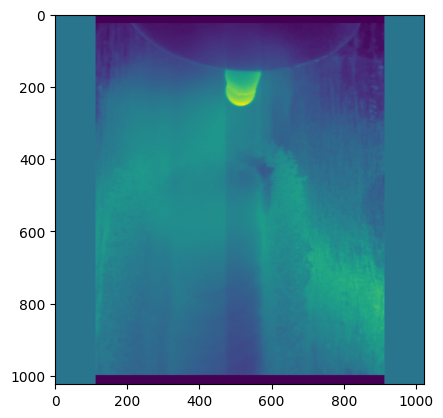

In [21]:
image_array_padded = np.nan_to_num(image_array_padded, nan=1/32)
plt.imshow(image_array_padded)

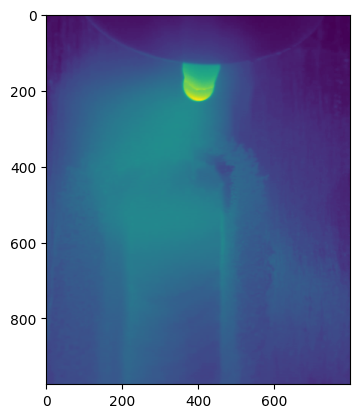

In [22]:
plt.imshow(image_array)

In [23]:
n_epochs = 50
n_layers = 2
kernel_size = 5

In [24]:
dev = qml.device('default.qubit', wires=kernel_size*kernel_size)

In [25]:
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi*phi[j], wires=j)
    
    for j in rand_params:
        RandomLayers([j], wires=list(range(4)))
    
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

In [26]:
def quanv(image, kernel_size=5, dilation=1, stride=1):
    left, top = 0, 0
    right = left + (kernel_size - 1)*dilation
    bottom = top + (kernel_size - 1)*dilation
    
    out = np.zeros((len(image)-bottom, len(image[0])-right, kernel_size*kernel_size))
    
    while bottom < len(image):
        while right < len(image[0]):
            image_pixels = []
            for y in range(top, bottom, dilation):
                for x in range(left, right, dilation):
                    image_pixels.append(image[y, x, 0])
            
            q_results = circuit([image_pixels])
            
            for c in range(kernel_size*kernel_size):
                out[bottom, right, c] = q_results[c]
            
            left += stride
            right = left + (kernel_size - 1)*dilation
        
        top += stride
        bottom = top + (kernel_size - 1)*dilation

In [27]:
def model():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(6, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [28]:
f = open('/kaggle/input/tig-aluminium-5083/al5083/train/train.json')
data = json.load(f)

file_names = []
labels = []

for key, item in data.items():
    file_names.append(key)
    labels.append(item)

file_names = np.array(file_names)
labels = np.array(labels)

len_photos = len(file_names)

indices = np.array([i for i in range(len_photos)])

f.close()

prop_train = 0.75
num_train = int(prop_train * len_photos)
num_test = len_photos - num_train

num_classes = len(np.unique(labels))
input_shape = (974, 800, 1)

training_indices = np.random.permutation(indices)

X_train = file_names[training_indices[:num_train]]
y_train = labels[training_indices[:num_train]]
X_test = file_names[training_indices[num_train:]]
y_test = labels[training_indices[num_train:]]

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X_train = X_train.numpy()
X_test = X_test.numpy()

In [29]:
q_model = model()

In [30]:
# epochs = 15
# batch_size = 64
# # batch_size = 16
# left = 0
# stride = 16

# box_start_index = 0

# # for box_start_index in range(0, len(X_test), batch_size):
# if True:
#     q_train_images = []
#     q_test_images = []
#     train_labels = []
#     test_labels = []
    
#     for image_index in range(box_start_index, box_start_index + (int((3/4)*batch_size))):
#         file_name = "/kaggle/input/tig-aluminium-5083/al5083/train/"
#         file_name += X_train[i]
#         img_temp = np.array(img.imread(file_name))

#         img_temp = img_temp.astype("float32") / 255
#         q_train_images.append(img_temp)
#         train_labels.append(y_train[image_index])
    
#     for image_index in range(box_start_index + (int((3/4)*batch_size)), box_start_index + batch_size):
#         file_name = "/kaggle/input/tig-aluminium-5083/al5083/train/"
#         file_name += X_train[i]
#         img_temp = np.array(img.imread(file_name))

#         img_temp = img_temp.astype("float32") / 255
#         q_test_images.append(img_temp)
#         test_labels.append(y_train[image_index])
    
#     q_history = q_model.fit(
#         q_train_images,
#         train_labels,
#         validation_data=(q_test_images, test_labels),
#         batch_size=4,
#         epochs=n_epochs,
#         verbose=2,
#     )

In [31]:
q_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
train_inner_size = 128
test_inner_size = 32

train_images_inner = []
train_labels_inner = []

test_images_inner = []
test_labels_inner = []

for index in range(train_inner_size):
    file_name = "/kaggle/input/tig-aluminium-5083/al5083/train/"
    file_name += X_train[index]
    img_temp = np.array(img.imread(file_name))

    img_temp = img_temp.astype("float32") / 255
    train_images_inner.append(img_temp)
    train_labels_inner.append(y_train[index])

In [35]:
for index in range(train_inner_size, train_inner_size + test_inner_size):
    file_name = "/kaggle/input/tig-aluminium-5083/al5083/train/"
    file_name += X_train[index]
    img_temp = np.array(img.imread(file_name))

    img_temp = img_temp.astype("float32") / 255
    test_images_inner.append(img_temp)
    test_labels_inner.append(y_train[index])

In [38]:
train_images_inner = np.array(train_images_inner)
train_labels_inner = np.array(train_labels_inner)

test_images_inner = np.array(test_images_inner)
test_labels_inner = np.array(test_labels_inner)

In [39]:
q_history = q_model.fit(
    train_images_inner,
    train_labels_inner,
    validation_data=(test_images_inner, test_labels_inner),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/50


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(4, 6), output.shape=(4, 6)